In [1]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from datetime import date
import calendar

In [2]:
# Import & Read CSV generated from DarkSky Weather API
csv_path1= "Resources/temp_weather.csv"
weather_df = pd.read_csv(csv_path1)
# Clean weather_df
del weather_df['Unnamed: 0']
del weather_df['index']

weather_df.head(1)

,Date,Temperature,Weather Condition
0,2016-02-12,20.53,Mostly Cloudy


In [3]:
# Import & Read CSV generated from Pittsburgh Crime Codes


In [4]:
#Import & Read Original Pittsburgh Crime Data CSV
csv_path3= "Resources/crime_data.csv"
master_df = pd.read_csv(csv_path3)
master_df.head(1)

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1975272,16158872,42.0,F,B,2016-08-24T12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551


In [5]:
# Clean master_df & Print Pittsburgh Crime DataFrame (organized_df)
# Split up ARRESTTIME column into Arrest Hour, Arrest Date, Arrest Month, Arrest Year, Arrest Unix Timestamp columns
master_df[['Date','Arrest_Time']]=master_df['ARRESTTIME'].str.split('T', expand=True,n=2)

# Drop unnecessary columns: PK, CCR, ARRESTLOCATION, OFFENSES, INCIDENTTRACT, COUNCIL_DISTRICT, PUBLIC_WORKS_DIVISION.
del master_df['PK']
del master_df['CCR']
del master_df['ARRESTTIME']
del master_df['ARRESTLOCATION']
del master_df['INCIDENTTRACT']
del master_df['COUNCIL_DISTRICT']
del master_df['PUBLIC_WORKS_DIVISION']
# Rename Columns
master_df.columns = ['Age', 'Gender', 'Race', 'Offenses Severity', 'Incident Location', 'Incident Neighborhood', 'Incident Zone', 'Incident Longitude', 'Incident Latitude', 'Date', 'Arrest_Time']
# Reorganize Columns
organized_df = master_df[['Age', 'Gender', 'Race', 'Offenses Severity', 'Date', 'Arrest_Time', 'Incident Location', 'Incident Latitude', 'Incident Longitude', 'Incident Neighborhood', 'Incident Zone']]
# View DataFrame
organized_df.head(1)

,Age,Gender,Race,Offenses Severity,Date,Arrest_Time,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone
0,42.0,F,B,3929 Retail Theft.,2016-08-24,12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",40.452551,-79.949277,Bloomfield,5


In [6]:
# Merge organized_df with weather_df
merged_df = weather_df.merge(organized_df, how="inner", on=["Date", "Date"])
merged_df.head(1)

,Date,Temperature,Weather Condition,Age,Gender,Race,Offenses Severity,Arrest_Time,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone
0,2016-02-12,20.53,Mostly Cloudy,24.0,F,B,"2701(a)(1) Simple Assault - Intent., Know., Re...",21:00:00,"1100 Block McKinney LANE Pittsburgh, PA 15205",40.423529,-80.035034,Ridgemont,6


In [7]:
# Clean & Organize merged_df
merged_df[['Arrest Year','Arrest Month','Arrest Date']]=merged_df['Date'].str.split('-', expand=True,n=2)
merged_df[['Arrest_Hour','Arrest_LongTime']]=merged_df['Arrest_Time'].str.split(':', expand=True,n=1)

# Convert "Arrest Month" column from Month Numbers to Month Names
look_up = {'01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May',
            '06': 'June', '07': 'July', '08': 'August', '09': 'September', '10': 'October', '11': 'November', '12': 'December'}
merged_df['Arrest Month'] = merged_df['Arrest Month'].apply(lambda x: look_up[x])

# Convert "Arrest Timestamp" column into "Arrest Day" column
merged_df['Date'] = pd.to_datetime(merged_df.Date) 
merged_df['Arrest Day of Week'] = merged_df.Date.dt.weekday_name

# Create 'Arrest Time of Day' column from 'Arrest Hour' column
merged_df["Arrest_Hour"] = pd.to_numeric(merged_df["Arrest_Hour"])
# Create bins in which to place values based upon Time of Day
day_bins = [0, 4, 8, 12, 16, 20, 24]
# Create labels for day_bins
day_labels = ["Early Morning", "Morning", "Late Morning", "Early Afternoon", "Early Evening", "Evening"]
# Create 'Arrest Time of Day' column for storing bins
merged_df['Arrest Time of Day'] = pd.cut(merged_df['Arrest_Hour'], day_bins, labels=day_labels)
# Deleter unwanted columns
del merged_df['Date']
del merged_df['Arrest_Time']
del merged_df['Arrest_LongTime']
del merged_df['Arrest_Hour']
# Reorganize columns
full_crime_df = merged_df[['Age', 'Gender', 'Race', 'Offenses Severity', 'Arrest Day of Week', 'Arrest Date', 'Arrest Month', 'Arrest Year', 'Temperature', 'Weather Condition', 'Incident Location', 'Incident Latitude', 'Incident Longitude', 'Incident Neighborhood', 'Incident Zone']]
# Show DataFrame
full_crime_df.head()


,Age,Gender,Race,Offenses Severity,Arrest Day of Week,Arrest Date,Arrest Month,Arrest Year,Temperature,Weather Condition,Incident Location,Incident Latitude,Incident Longitude,Incident Neighborhood,Incident Zone
0,24.0,F,B,"2701(a)(1) Simple Assault - Intent., Know., Re...",Friday,12,February,2016,20.53,Mostly Cloudy,"1100 Block McKinney LANE Pittsburgh, PA 15205",40.423529,-80.035034,Ridgemont,6
1,31.0,M,W,13(a)(16) Possession of Controlled Substance /...,Wednesday,17,February,2016,32.76,Overcast,"800 Block Concord ST Pittsburgh, PA 15212",40.457564,-79.997924,East Allegheny,1
2,31.0,F,O,9015 Failure To Appear/Arrest on Attachment Order,Thursday,03,March,2016,34.11,Partly Cloudy,"600 Block Liberty AV Pittsburgh, PA 15222",40.441773,-80.001620,Central Business District,2
3,22.0,M,W,2702 Aggravated Assault. / 2706 Terroristic Th...,Monday,04,April,2016,50.96,Light Rain,"S 15th ST & E Carson ST Pittsburgh, PA 15203",40.428815,-79.983425,South Side Flats,3
4,36.0,M,W,13(a)(32) Paraphernalia - Use or Possession,Friday,08,April,2016,39.39,Overcast,"Boyd ST & Diamond ST Pittsburgh, PA 15219",40.438656,-79.993293,Bluff,2


In [44]:
full_crime_df.describe()

,Age,Temperature,Incident Latitude,Incident Longitude
count,26958.000000,27073.000000,26225.000000,26225.000000
mean,33.004118,59.805419,38.048562,-75.240234
std,15.163983,18.609546,9.546221,18.877464
min,0.000000,7.270000,0.000000,-80.487212
25%,24.000000,44.030000,40.423437,-80.005189
50%,30.000000,63.920000,40.446315,-79.985057
75%,40.000000,76.090000,40.458674,-79.930661
max,999.000000,90.990000,41.233036,0.000000


In [8]:
# Weather vs Crime Frequency / Crime Type
    # Temperature (Hot vs Cold)
        # X-Axis: Temperature (Ex. Very Cold, Cold, Moderate, Hot, Very Hot, etc.)
        # Y-Axis: Amount of Crime (measured by incident number)
    # Weather Condition: 
        # X-Axis: Type of weather (ie rain, sun, snow, etc.)
        # Y-Axis: Amount of Crime (measured by incident number)


In [ ]:
# Crime Frequency vs Incident Location (Heatmap) (Liam)
    # Crime Frequency vs Police Zone (Heatmap) (Liam)


In [ ]:
# Crime Severity vs Incident Location (Heatmap) (Liam)


In [ ]:
# Age, Gender and Race vs Crime (Pie Charts?)
    # Crime Frequency
        # Grouped by incident location & date
        
    # Crime Type
    
    # Crime Severity (Felonies, Misdemeanors or Violations/Infractions)


In [20]:
new_full_crime_df = full_crime_df[(full_crime_df.Age > 0) & (full_crime_df.Age <= 100)]

In [45]:
new_full_crime_df.describe()

,Age,Temperature,Incident Latitude,Incident Longitude
count,26936.000000,26824.000000,25987.000000,25987.000000
mean,32.952554,59.811328,38.037533,-75.218432
std,12.641691,18.607776,9.566814,18.918189
min,10.000000,7.270000,0.000000,-80.487212
25%,24.000000,44.110000,40.423327,-80.005189
50%,30.000000,63.920000,40.446315,-79.985085
75%,40.000000,76.090000,40.458682,-79.930665
max,98.000000,90.990000,41.233036,0.000000


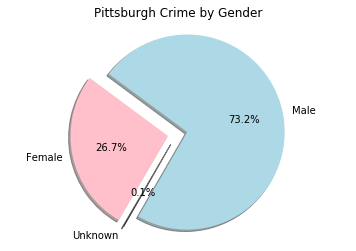

In [23]:
gender_count = new_full_crime_df["Gender"].value_counts()
total_gender_count = new_full_crime_df["Gender"].count()
gender_percentage = (gender_count/total_gender_count) *100

Gender = ["Male", "Female", "Unknown"]
Percent = [gender_percentage]
colors = ["LightBlue", "Pink", "Black"]
explode = (0.1, 0.1, 0.1)


plt.pie(gender_percentage, explode=explode, labels=Gender, colors=colors, autopct="%1.1f%%", shadow=True, startangle= 240)
plt.axis("equal")
plt.title("Pittsburgh Crime by Gender")

plt.show()

In [ ]:
new_full_crime_df.groupby(['Gender','Race'])['Age'].mean().unstack().plot.bar()

Text(0.5, 1.0, 'Pittsburgh Crime by Race')

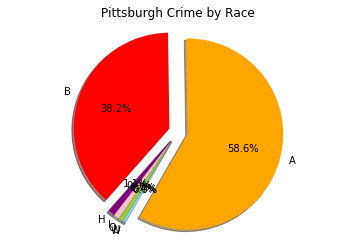

In [32]:
race_count = new_full_crime_df["Race"].value_counts()
total_race_count = new_full_crime_df["Race"].count()
race_percentage = (race_count/total_race_count) *100

Race = ["A", "B", "H", "I", "O", "U","W"]
Percent = [race_percentage]
colors = ["orange", "red", "purple", "pink", "yellowgreen", "lightskyblue", "lightcoral"]
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)


plt.pie(race_percentage, explode=explode, labels=Race, colors=colors, autopct="%1.1f%%", shadow=True, startangle= 240)
plt.axis("equal")
plt.title("Pittsburgh Crime by Race")


Text(0.5, 0, 'Race Type')

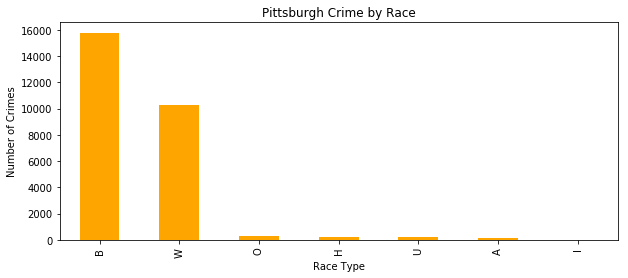

In [33]:
race_data = new_full_crime_df["Race"].value_counts()
race_data.plot.bar(align="center", figsize=(10,4), color= "orange")
plt.title("Pittsburgh Crime by Race")
plt.ylabel("Number of Crimes")
plt.xlabel("Race Type")

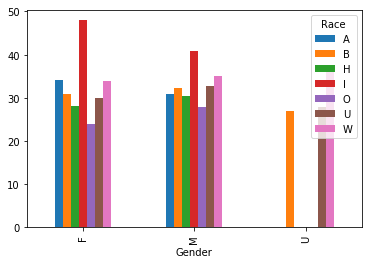

In [34]:
new_full_crime_df.groupby(['Gender','Race'])['Age'].mean().unstack().plot.bar()

In [42]:
#Establish bins for ages
bins = [18,25,30,35,40,45,50,55,60,65,70,80,90,100]

group_labels = ["<18","18-25","25-30","30-35","35-40","40-45","45-50","50-55", "55-60","60-65","65-70", "70-80", ">80"]

In [43]:
pd.cut(new_full_crime_df["Age"], bins, labels = group_labels).head(10)

0      <18
1    25-30
2    25-30
3      <18
4    30-35
5    50-55
6    45-50
7      <18
8    18-25
9    18-25
Name: Age, dtype: category
Categories (13, object): [<18 < 18-25 < 25-30 < 30-35 ... 60-65 < 65-70 < 70-80 < >80]

In [ ]:
Age_df["Age_group"] = pd.cut(Age_df["AGE"], bins, labels = group_labels) 

In [ ]:
Age_df = full_crime_df.loc[:,["Age","Race", "Gender"]]

In [ ]:
race_gender_group= full_crime_df.groupby(['Race','Gender'])

In [ ]:
race_gender_group.plot(kind="bar", title="Gender")

In [ ]:
#full_crime_df.groupby(['Gender','Race']).count().unstack().plot.bar()

In [47]:
Arrest_Year_group = full_crime_df.groupby(["Arrest Year","Arrest Month"]).count()
Arrest_Year_group

Age  Gender  Race  Offenses Severity  \
Arrest Year Arrest Month                                          
2016        April           11      11    11                 11   
            August         640     656   656                656   
            December       827     836   836                836   
            February         2       2     2                  2   
            July            13      13    13                 13   
            March            1       1     1                  1   
            November       861     869   869                869   
            October        883     890   890                890   
            September      856     864   864                864   
2017        April          953     968   968                968   
            August        1016    1026  1026               1026   
            December       854     861   861                861   
            February       945     959   959                959   
            January        977     988   988                988   
            July          1099    1114  1114               1114   
            June          1115    1120  1120               1120   
            March         1005    1015  1015               1015   
            May           1034    1046  1046               1046   
            November       980     987   987                987   
            October       1015    1020  1020               1020   
            September     1064    1071  1071               1071   
2018        April          936     943   943                943   
            August         999    1003  1003               1002   
            December       770     772   772                772   
            February       849     856   856                856   
            January        921     927   927                927   
            July           896     904   904                903   
            June           882     885   885                885   
            March          931     941   941                941   
            May           1054    1056  1056               1055   
            November       759     764   764                764   
            October        863     869   869                869   
            September      910     912   912                912   
2019        January         37      37    37                 37   

                          Arrest Day of Week  Arrest Date  Temperature  \
Arrest Year Arrest Month                                                 
2016        April                         11           11           11   
            August                       656          656          656   
            December                     836          836          836   
            February                       2            2            2   
            July                          13           13           13   
            March                          1            1            1   
            November                     869          869          869   
            October                      890          890          890   
            September                    864          864          864   
2017        April                        968          968          968   
            August                      1026         1026         1026   
            December                     861          861          861   
            February                     959          959          959   
            January                      988          988          988   
            July                        1114         1114         1114   
            June                        1120         1120         1120   
            March                       1015         1015         1015   
            May                         1046         1046         1046   
            November                     987          987          987   
            October                     1020         1020   

In [ ]:
#PH# Crime Frequency vs Time of Year (seasonality)
#crime_plot = full_crime_df.groupby(["Arrest Year","Arrest Month"]).count().stack().plot.bar()
#crime_plot.set_xlabel('Arrest Year')
#crime_plot.set_ylabel('OFFENSES')
#crime_plot.set_title('crime vs time of year')

In [ ]:
#PH# Crime Frequency vs Time of Year (seasonality)

# Split data into groups based upon day of week
#month_groups = organized_df.groupby('Arrest Month').sum()

#sorter2 = ['January', 'Febraury', 'March', 'April', 'May', 'June', 
#          'July', 'August', 'September', 'October', 'November', 'December']
#sorterIndex = dict(zip(sorter2,range(len(sorter2))))

#month_groups['Month_id'] = month_groups.index
#month_groups['Month_id'] = month_groups['Month_id'].map(sorterIndex)
#month_groups.sort_values('Month_id', inplace=True)

#fig, ax = plt.subplots(facecolor='white')
 
#ax.bar(month_groups.Month_id, month_groups.Criminal)
#ax.set_xticks(month_groups.Month_id)
#ax.set_xticklabels(month_groups.index)

# Edit
    # Change Colors
    # Make Labels Diagonal
    # Change Y-Axis meaurements

In [ ]:
#Time_df = full_crime_df.loc[:,["Arrest Year","Arrest Month"]]
#Arrest_Year_group = Time_df.groupby(["Arrest Year","Arrest Month"]).count()


In [ ]:
# Crime Severity vs Time of Year (seasonality)
#Arrest month vs len(grouped(Incident Severity))
# X-Axis: Months
# Y-Axis: Severity of Crime (measured by incident number)


In [ ]:
#PH# Crime Frequency vs Day of Week

# Split data into groups based upon day of week
#day_groups = organized_df.groupby('Arrest Day of Week').sum()

#sorter = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
#sorterIndex = dict(zip(sorter,range(len(sorter))))

#day_groups['Day_id'] = day_groups.index
#day_groups['Day_id'] = day_groups['Day_id'].map(sorterIndex)
#day_groups.sort_values('Day_id', inplace=True)

#fig, ax = plt.subplots(facecolor='white')
 
#ax.bar(day_groups.Day_id, day_groups.Criminal)
#ax.set_xticks(day_groups.Day_id)
#ax.set_xticklabels(day_groups.index)


In [ ]:
# Crime Severity vs Day of Week
#Arrest Day of Week vs len(grouped(Incident Severity))
# X-Axis: Day (Monday, Tuesday, Wednesday, etc.)
# Y-Axis: Severity of Crime (measured by incident type)


In [ ]:
#PH# Crime Frequency vs Time of Day 

# Split data into groups based upon day of week
#time_of_day_groups = organized_df.groupby('Arrest Time of Day')
# Find out how many arrests occured during each month group
#incidents_time_of_day = time_of_day_groups['Criminal'].count()
# Chart our data, give it a title, and label the axes
#incidents_time_of_day_chart = incidents_time_of_day.plot(kind="bar", title="Crime Frequency vs. Time of Day")
#incidents_time_of_day_chart.set_xlabel("Time of Day")
#incidents_time_of_day_chart.set_ylabel("Amount of Crime (Per Incident)")
#plt.xticks(rotation = 45)


#plt.tight_layout()

# Edit
# Change Colors
# Make Labels Diagonal
# Change Y-Axis meaurements

In [ ]:
# Crime Severity vs Time of Day 
# X-Axis: Time of Day (early morning, morning, early afternoon, noon, etc.)
# Y-Axis: Severity of Crime (measured by incident type)
